# From Data to Downturn: Predicting Recessions Using Economic Indicators

In [537]:
# importing libraries

import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

# Replace with your FRED API key
API_KEY = "f26e07fed4df3480555e31cb4a772df7"

In [538]:

# List of economic indicators and their FRED series IDs

indicators = {
    "Industrial Production": "INDPRO",
    "Capacity Utilization": "TCU", 
    "Brave-Butters-Kelley Real Gross Domestic Product": "BBKMGDP",  

    # Labor Market Data
    "Unemployment Rate": "UNRATE",
    "Total Nonfarm Employment": "PAYEMS", 
    "Labor Force Participation": "CIVPART", 
    "Civilian Labor Force": "CLF16OV", 

    # Inflation & Prices Data
    "CPI (Inflation)": "CPIAUCSL", 
    "CPI (All Urban Consumers)": "CPIAUCNS",
    "Core CPI": "CPILFESL",
    "PPI (Wholesale Inflation)": "PPIACO", 

    # Monetary & Financial Data
    "Federal Funds Rate": "FEDFUNDS", 
    "Real M1 Money Supply": "M1SL", 
    "Real M2 Money Supply": "M2SL", 

    # Interest Rate Data
    "10-Year Treasury Constant Maturity Rate": "GS10", 
    "5-Year Treasury Constant Maturity Rate": "GS5", 
    "7-Year Treasury Constant Maturity Rate": "GS7", 
    "30-Year Treasury Constant Maturity Rate": "GS30", 
    "3-Year Treasury Constant Maturity Rate": "GS3", 
    "2-Year Treasury Constant Maturity Rate": "GS2", 
    "1-Year Treasury Constant Maturity Rate": "GS1", 
    "3-Month Treasury Constant Maturity Rate": "GS3M", 

    # Consumer and Business Sentiment Data
    "Consumer Sentiment": "UMCSENT", 
    'Personal Consumption Expenditures': 'PCE',
    'Real Disposable Personal Income': 'DSPIC96',
    "Total Consumer Credit": "TOTALSL", 

    # Trade Data
    "Trade Balance": "NETEXP", 
    "Exports of Goods and Services": "EXPGS", 
    "Imports of Goods and Services": "IMPGS", 

    # Housing Data
    "New Private Housing Units Authorized by Building Permits": "PERMIT", 
    "New Private Housing Units Started": "HOUST", 
    "Median Sales Price for New Houses Sold in the United States": "MSPNHSUS",

    # Productivity Data
    "Nonfarm Business Sector: Real Output per Hour of All Persons": "OPHNFB", 

    # GDP Data
    "Gross Domestic Product": "GDP", 
    "Real Gross Domestic Product": "GDPC1",

    "NBER based Recession Indicators for the United States from the Period following the Peak through the Trough": "USREC"
}


In [ ]:
# Function to fetch data from FRED
def fetch_fred_data(series_id):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={API_KEY}&file_type=json"
    response = requests.get(url)
    data = response.json()
    
    if "observations" not in data:
        print(f"Error fetching data for series {series_id}: {data}")
        return pd.DataFrame(columns = ["date", series_id])

    df = pd.DataFrame(data["observations"])
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = df["value"].replace(".", None).astype(float)
    
    return df[["date", "value"]].rename(columns = {"value": series_id})

# Fetch data for all indicators
economic_data = None
for name, series in indicators.items():
    df = fetch_fred_data(series)
    if economic_data is None:
        economic_data = df
    else:
        economic_data = economic_data.merge(df, on = "date", how = "outer")

In [ ]:
economic_data.to_csv("data/economic_data.csv", index = False)
print("Data fetched and saved to economic_data.csv")

Data fetched and saved to economic_data.csv


In [ ]:
economic_data = pd.read_csv("data/economic_data.csv", parse_dates=["date"])

In [ ]:
economic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2045 entries, 0 to 2044
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2045 non-null   datetime64[ns]
 1   INDPRO    1275 non-null   float64       
 2   TCU       699 non-null    float64       
 3   BBKMGDP   783 non-null    float64       
 4   UNRATE    928 non-null    float64       
 5   PAYEMS    1036 non-null   float64       
 6   CIVPART   928 non-null    float64       
 7   CLF16OV   928 non-null    float64       
 8   CPIAUCSL  940 non-null    float64       
 9   CPIAUCNS  1348 non-null   float64       
 10  CPILFESL  820 non-null    float64       
 11  PPIACO    1347 non-null   float64       
 12  FEDFUNDS  850 non-null    float64       
 13  M1SL      795 non-null    float64       
 14  M2SL      795 non-null    float64       
 15  GS10      865 non-null    float64       
 16  GS5       865 non-null    float64       
 17  GS7       670 

In [ ]:
# Truncating the data to the specified date range

start_date = pd.to_datetime('1982-01-01')
end_date = pd.to_datetime('2024-12-31')

truncated_data = economic_data[(economic_data['date'] >= start_date) & (df['date'] <= end_date)].reset_index(drop = True)

In [ ]:
# gold data

gold_df = pd.read_csv("data/gold.csv", parse_dates = ["Date"])
gold_df.rename(columns = {'Date': 'date', 'Price': 'gold'}, inplace = True)

In [ ]:
gold = truncated_data.merge(gold_df, on = 'date', how = 'inner')

In [ ]:
# Stock Market Data

sp_data = pd.read_csv("data/sp500.csv", parse_dates = ["Date"])
sp_data.rename(columns = {'Date': 'date', 'Price': 'SP500'}, inplace = True)
sp_data = sp_data[['date', 'SP500']]

dj_data = pd.read_csv("data/dji.csv", parse_dates = ["Date"])
dj_data.rename(columns = {'Date': 'date', 'Price': 'DJI'}, inplace = True)
dj_data = dj_data[['date', 'DJI']]

In [ ]:
# creating a final dataframe

sp = gold.merge(sp_data, on = 'date', how = 'inner')
final_df = sp.merge(dj_data, on = 'date', how = 'inner')
final_df[['OPHNFB', 'GDP', 'GDPC1', 'NETEXP', 'EXPGS', 'IMPGS']] = final_df[['OPHNFB', 'GDP', 'GDPC1', 'NETEXP', 'EXPGS', 'IMPGS']].ffill()
final_df.dropna()

,date,INDPRO,TCU,BBKMGDP,UNRATE,PAYEMS,CIVPART,CLF16OV,CPIAUCSL,CPIAUCNS,...,PERMIT,HOUST,MSPNHSUS,OPHNFB,GDP,GDPC1,USREC,gold,SP500,DJI
0,1982-01-01,48.7877,75.1290,-11.435516,8.6,90565.0,63.7,109089.0,94.400,94.300,...,794.0,843.0,66200.0,49.612,3274.302,7295.631,1.0,384.14,120.40,871.10
1,1982-02-01,49.7839,76.4962,3.784668,8.9,90563.0,63.8,109467.0,94.700,94.600,...,808.0,866.0,65700.0,49.612,3274.302,7295.631,1.0,374.13,113.10,824.39
2,1982-03-01,49.4477,75.8210,0.851504,9.0,90434.0,63.8,109567.0,94.700,94.500,...,891.0,931.0,67200.0,49.612,3274.302,7295.631,1.0,330.25,112.00,822.77
3,1982-04-01,48.9913,74.9732,2.119495,9.3,90150.0,63.9,109820.0,95.000,94.900,...,888.0,917.0,70200.0,49.626,3331.972,7328.912,1.0,350.30,116.40,848.36
4,1982-05-01,48.6669,74.3382,3.017985,9.4,90107.0,64.2,110451.0,95.900,95.800,...,953.0,1025.0,69300.0,49.626,3331.972,7328.912,1.0,333.71,111.90,819.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2024-08-01,103.0196,77.8658,3.449988,4.2,158074.0,62.7,168496.0,314.131,314.796,...,1470.0,1379.0,405800.0,115.241,29374.914,23400.294,0.0,2470.15,"5,648.40","41,563.08"
512,2024-09-01,102.5954,77.4591,3.613510,4.1,158314.0,62.7,168703.0,314.851,315.301,...,1425.0,1355.0,421100.0,115.241,29374.914,23400.294,0.0,2570.55,"5,762.48","42,330.15"
513,2024-10-01,102.2138,77.0806,2.476297,4.1,158358.0,62.5,168428.0,315.564,315.664,...,1419.0,1344.0,426300.0,115.725,29723.864,23542.349,0.0,2690.08,"5,705.45","41,763.46"
514,2024-11-01,101.9619,76.7963,1.871748,4.2,158619.0,62.5,168304.0,316.449,315.493,...,1493.0,1305.0,397600.0,115.725,29723.864,23542.349,0.0,2651.13,"6,032.38","44,910.65"


In [ ]:
# converting columns to float

final_df['SP500'] = final_df['SP500'].str.replace(',', '').astype(float)
final_df['DJI'] = final_df['DJI'].str.replace(',', '').astype(float)

In [ ]:
# Renaming columns for clarity

final_df.rename(columns = {
                                'date': 'date',
                                'INDPRO': 'industrial_production', 
                                'TCU': 'capacity_utilization',
                                'BBKMGDP': 'real_GDP_growth_rate', 
                                'UNRATE': 'unemployment_rate', 
                                'PAYEMS': 'nonfarm_payroll', 
                                'CIVPART': 'laborforce_participation', 
                                'CLF16OV': 'civilian_labor_force',
                                'CPIAUCSL': 'CPI',
                                'CPIAUCNS': 'CPI_all_urban_consumers',
                                'CPILFESL': 'core_CPI',
                                'PPIACO': 'PPI',
                                'FEDFUNDS': 'federal_funds_rate',
                                'M1SL': 'real_M1_money_supply_growth',
                                'M2SL': 'real_M2_money_supply_growth', 
                                'GS10': '10Y_treasury_yield',
                                'GS5': '5Y_treasury_yield',
                                'GS7': '7Y_treasury_yield',
                                'GS30': '30Y_treasury_yield',
                                'GS3': '3Y_treasury_yield',
                                'GS2': '2Y_treasury_yield',
                                'GS1': '1Y_treasury_yield',
                                'GS3M': '3M_treasury_yield',
                                'PCE': 'personal_consumption_expenditures',
                                'DSPIC96': 'real_disposable_personal_income',
                                'TOTALSL': 'total_consumer_credit',
                                'NETEXP': 'trade_balance',
                                'EXPGS': 'exports_of_goods_and_services',
                                'IMPGS': 'imports_of_goods_and_services',
                                'UMCSENT': 'consumer_sentiment',
                                'PERMIT': 'building_permits',
                                'HOUST': 'housing_start', 
                                'MSPNHSUS': 'median_sale_price_new_houses',
                                'OPHNFB': 'nonfarm_business_sector_real_output_per_hour',
                                'GDP': 'GDP',
                                'GDPC1': 'real_GDP',
                                'USREC': 'recession',
                                'gold': 'gold_price',
                                'SP500': 'SP500_price',
                                'DJI': 'DJI_price'
                                }, 
                                inplace = True
                )

In [ ]:
final_df = final_df.sort_values('date')

In [ ]:
final_df.tail()

,date,industrial_production,capacity_utilization,real_GDP_growth_rate,unemployment_rate,nonfarm_payroll,laborforce_participation,civilian_labor_force,CPI,CPI_all_urban_consumers,...,building_permits,housing_start,median_sale_price_new_houses,nonfarm_business_sector_real_output_per_hour,GDP,real_GDP,recession,gold_price,SP500_price,DJI_price
511,2024-08-01,103.0196,77.8658,3.449988,4.2,158074.0,62.7,168496.0,314.131,314.796,...,1470.0,1379.0,405800.0,115.241,29374.914,23400.294,0.0,2470.15,5648.40,41563.08
512,2024-09-01,102.5954,77.4591,3.613510,4.1,158314.0,62.7,168703.0,314.851,315.301,...,1425.0,1355.0,421100.0,115.241,29374.914,23400.294,0.0,2570.55,5762.48,42330.15
513,2024-10-01,102.2138,77.0806,2.476297,4.1,158358.0,62.5,168428.0,315.564,315.664,...,1419.0,1344.0,426300.0,115.725,29723.864,23542.349,0.0,2690.08,5705.45,41763.46
514,2024-11-01,101.9619,76.7963,1.871748,4.2,158619.0,62.5,168304.0,316.449,315.493,...,1493.0,1305.0,397600.0,115.725,29723.864,23542.349,0.0,2651.13,6032.38,44910.65
515,2024-12-01,103.1177,77.5686,-0.069538,4.1,158942.0,62.5,168547.0,317.603,315.605,...,1482.0,1526.0,423000.0,115.725,29723.864,23542.349,0.0,2648.01,5881.63,42544.22


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   date                                          516 non-null    datetime64[ns]
 1   industrial_production                         516 non-null    float64       
 2   capacity_utilization                          516 non-null    float64       
 3   real_GDP_growth_rate                          516 non-null    float64       
 4   unemployment_rate                             516 non-null    float64       
 5   nonfarm_payroll                               516 non-null    float64       
 6   laborforce_participation                      516 non-null    float64       
 7   civilian_labor_force                          516 non-null    float64       
 8   CPI                                           516 non-null    float64 

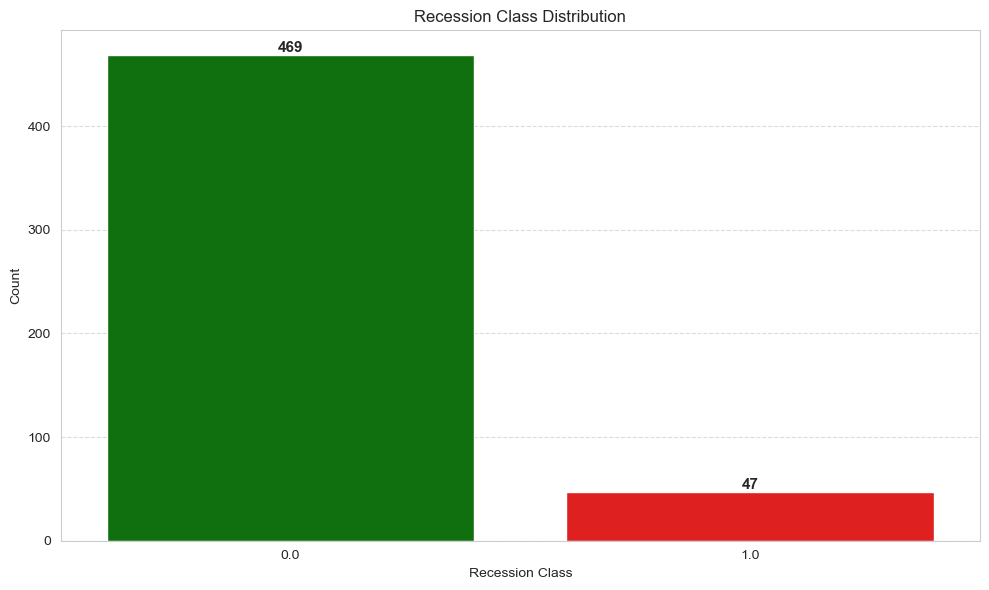

In [ ]:
#  Recession class distribution
sns.set_style("whitegrid")
colors = ['green', 'red']
plt.figure(figsize = (10, 6))
ax = sns.countplot(data = final_df, x = 'recession', hue = 'recession', palette = colors, legend = False)
plt.xlabel("Recession Class")
plt.ylabel("Count")
plt.title("Recession Class Distribution")
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}',
                (p.get_x() + p.get_width() / 2, count),
                ha = 'center', va = 'bottom', fontsize = 11, fontweight = 'bold')

plt.tight_layout()
plt.show()

In [ ]:
# Descriptive statistics of the numerical features
final_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,516,2003-06-16 19:54:25.116279040,1982-01-01 00:00:00,1992-09-23 12:00:00,2003-06-16 00:00:00,2014-03-08 18:00:00,2024-12-01 00:00:00,NaN
industrial_production,516.0,83.663653,46.8713,63.94705,90.844,99.19555,104.1038,18.068011
capacity_utilization,516.0,78.905287,64.6982,76.83445,79.2721,81.159775,85.1871,3.584018
real_GDP_growth_rate,516.0,2.70888,-73.416841,1.164363,2.935768,4.536298,44.598172,5.665758
unemployment_rate,516.0,5.998837,3.4,4.6,5.6,7.1,14.8,1.825961
nonfarm_payroll,516.0,126685.664729,88771.0,109761.0,130801.5,138292.5,158942.0,18249.911448
laborforce_participation,516.0,64.958333,60.1,63.175,65.7,66.4,67.3,1.723844
civilian_labor_force,516.0,142770.236434,109089.0,128458.75,146492.5,155717.5,168703.0,16833.152429
CPI,516.0,188.845266,94.4,141.55,183.8,235.39325,317.603,58.401249
CPI_all_urban_consumers,516.0,188.843171,94.3,141.675,184.05,234.73675,315.664,58.40932


In [ ]:
# Correlation with the target variable
corr_target = final_df.corr(numeric_only = True)['recession'].sort_values(ascending = False)
print(corr_target)

recession                                       1.000000
unemployment_rate                               0.197739
30Y_treasury_yield                              0.148271
10Y_treasury_yield                              0.146430
7Y_treasury_yield                               0.138185
federal_funds_rate                              0.134350
5Y_treasury_yield                               0.133298
3Y_treasury_yield                               0.123956
2Y_treasury_yield                               0.119019
1Y_treasury_yield                               0.116464
3M_treasury_yield                               0.104573
laborforce_participation                        0.096048
trade_balance                                   0.064085
PPI                                            -0.085451
civilian_labor_force                           -0.097332
total_consumer_credit                          -0.103651
imports_of_goods_and_services                  -0.106401
real_disposable_personal_income

The correlation analysis reveals the strength and direction of linear relationships between various economic indicators and the occurrence of a recession. As expected, the recession variable has a perfect correlation with itself (1.0). Among the positively correlated features, the unemployment rate (0.198) and various Treasury yields such as the 30-year (0.148), 10-year (0.146), and federal funds rate (0.134) show mild positive associations with recessions. This suggests that during or just before recessions, interest rates and unemployment may rise slightly, possibly reflecting tightening financial conditions or deteriorating labor markets.

Conversely, several variables exhibit moderate to strong negative correlations with recessions. Notably, consumer sentiment (-0.379) and the real GDP growth rate (-0.369) show the strongest negative correlations, indicating that consumer confidence and economic growth tend to decline significantly during recessionary periods. Other indicators such as building permits (-0.312), capacity utilization (-0.305), and housing starts (-0.287) also show moderate negative correlations, highlighting that construction activity and industrial usage shrink during economic downturns.

Market indices like the S&P 500 (-0.151) and Dow Jones Industrial Average (-0.148) are slightly negatively correlated with recessions, which aligns with the general decline in equity markets during economic contractions. Similarly, GDP (-0.118) and nonfarm payroll (-0.117) show weak negative correlations, reflecting reduced output and employment during recessions.

Overall, the analysis confirms that economic output, consumer behavior, and business activity generally decline during recessions, while unemployment and some interest rates show slight increases, consistent with typical recession dynamics.

Text(0.5, 1.0, 'Correlation Matrix of Top Features')

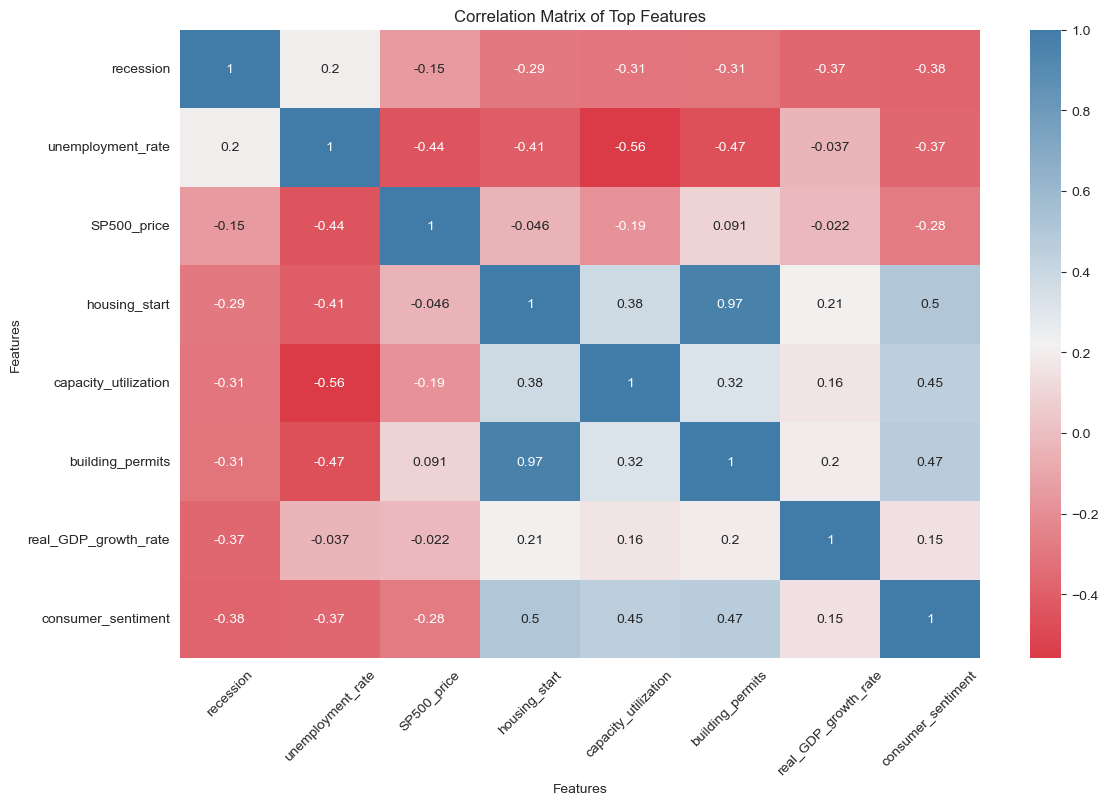

In [ ]:
# Heatmap of top correlated features with the target variable

top_corr_features = corr_target[abs(corr_target) > 0.15].index.tolist()
plt.figure(figsize = (12, 8))
sns.heatmap(final_df[top_corr_features].corr(), annot = True, cmap = sns.diverging_palette(10, 240, as_cmap = True))
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.xlabel("Features")
plt.ylabel("Features")
plt.grid(False)
plt.tight_layout()
plt.title("Correlation Matrix of Top Features")

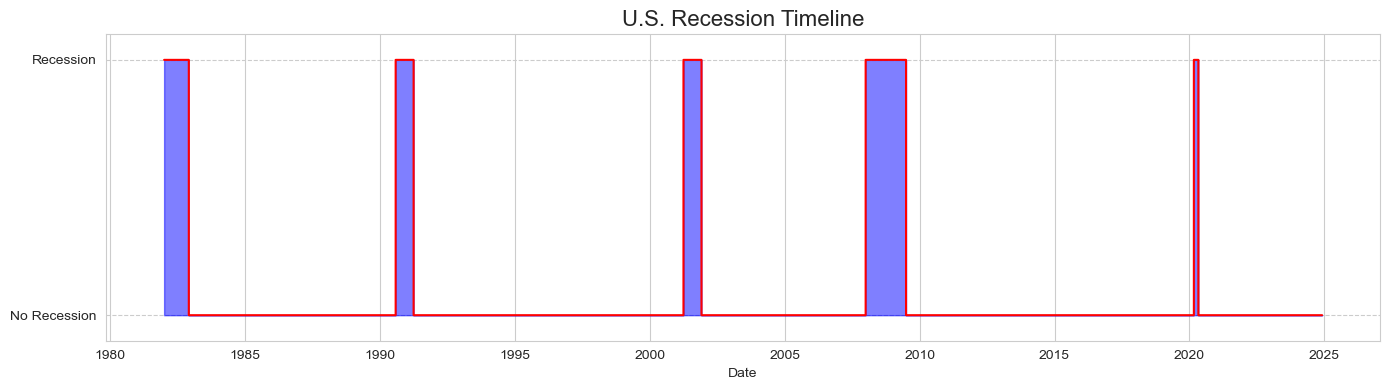

In [ ]:
# Recession over time 

sns.set_style("whitegrid")
plt.figure(figsize = (14, 4))
sns.lineplot(data = final_df, x = 'date', y = 'recession', drawstyle = 'steps-post', color = 'red')
plt.fill_between(final_df['date'], final_df['recession'], step = 'post', alpha = 0.5, color = 'blue')
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1], ['No Recession', 'Recession'])
plt.xlabel("Date")
plt.ylabel("")
plt.title("U.S. Recession Timeline", fontsize = 16)
plt.grid(axis = 'y', linestyle = '--', alpha = 1)
plt.tight_layout()
plt.show()



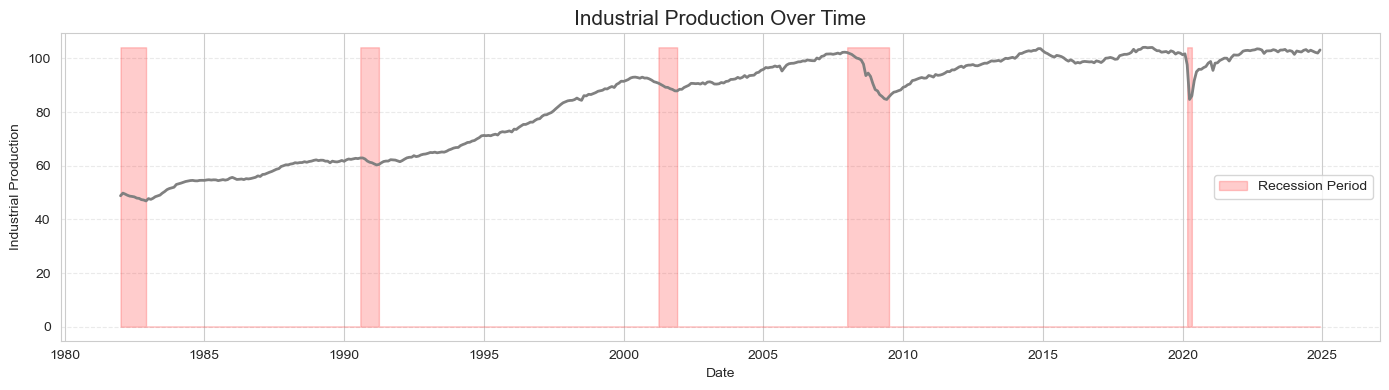

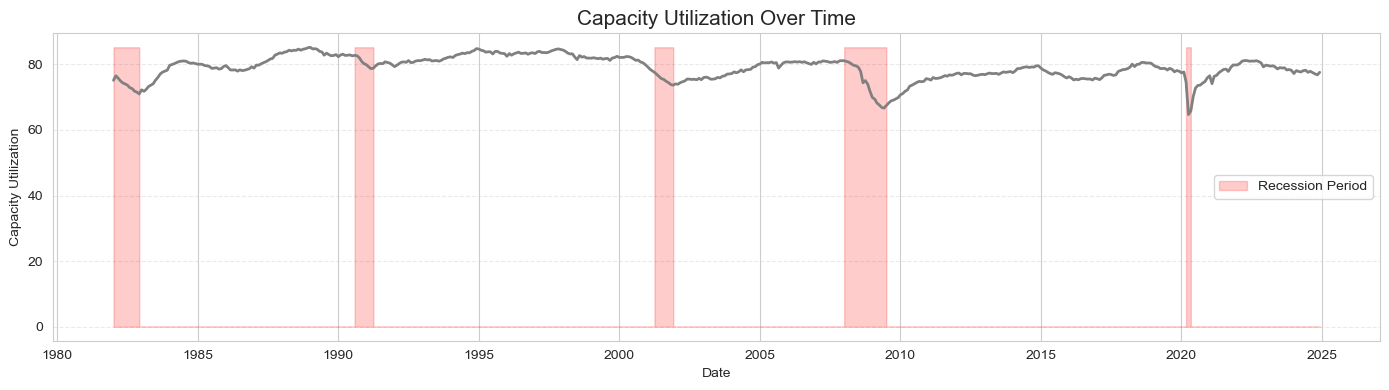

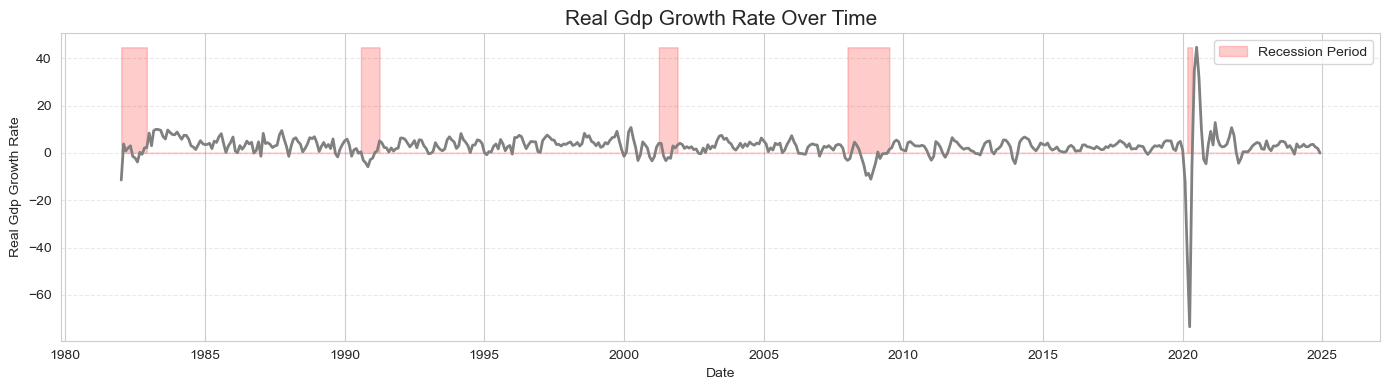

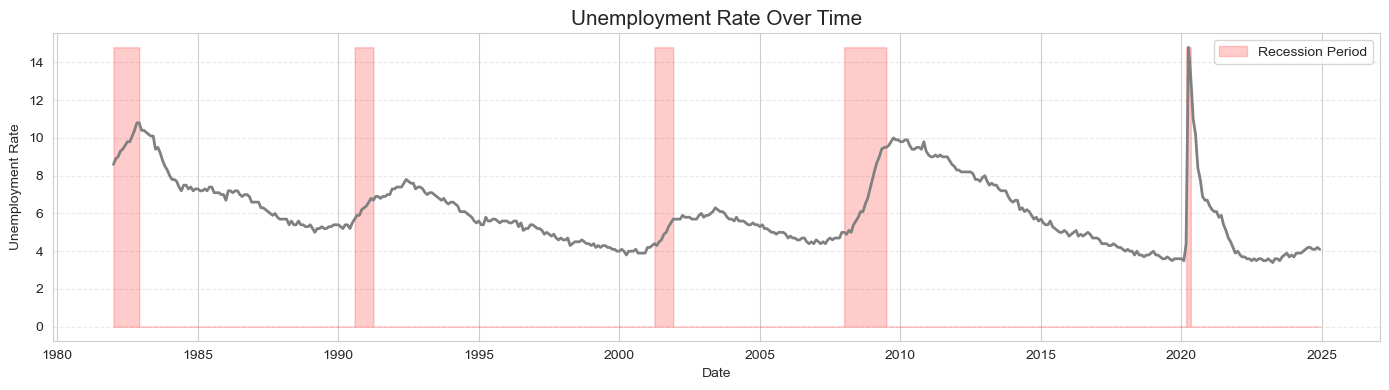

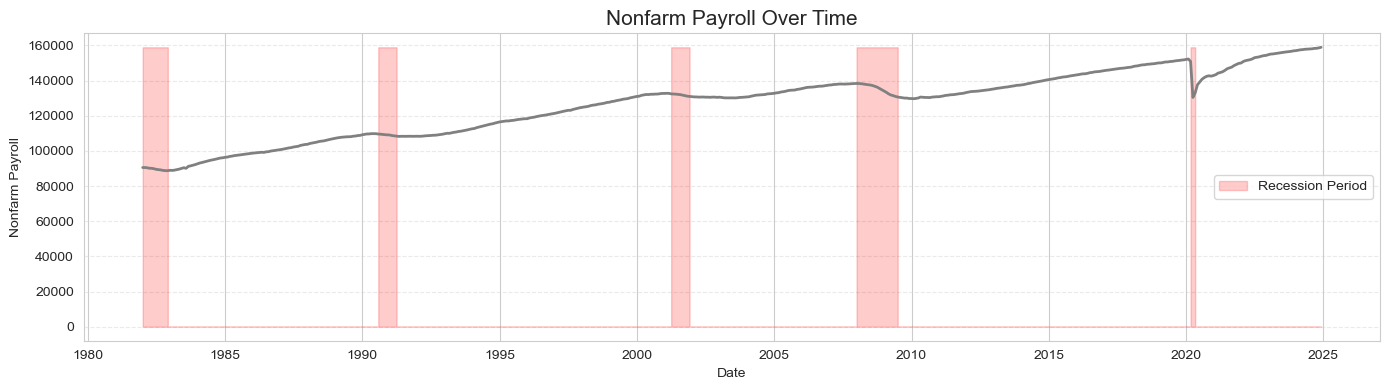

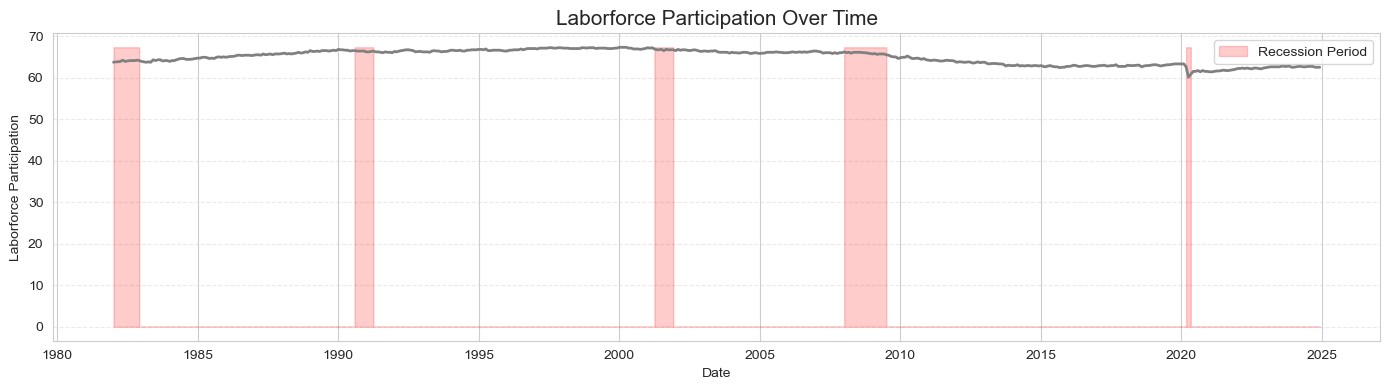

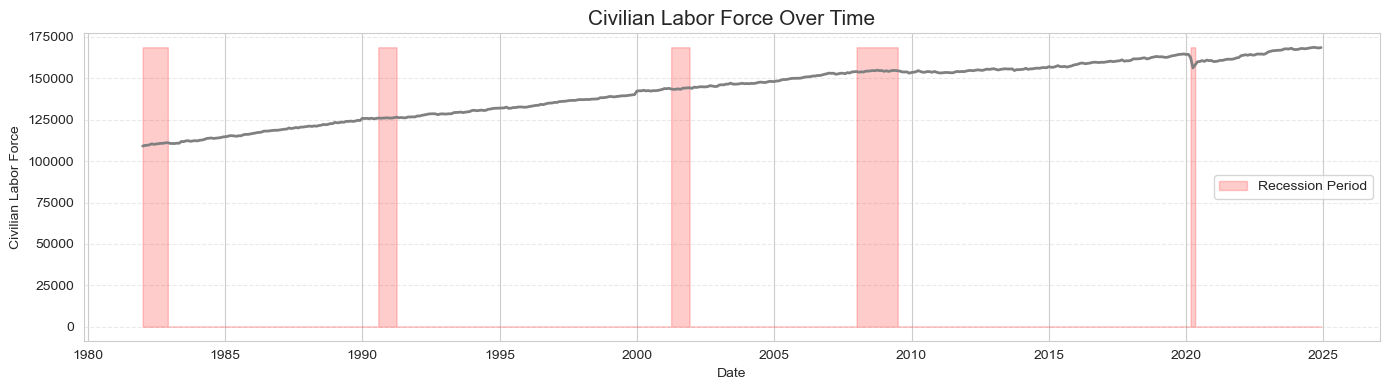

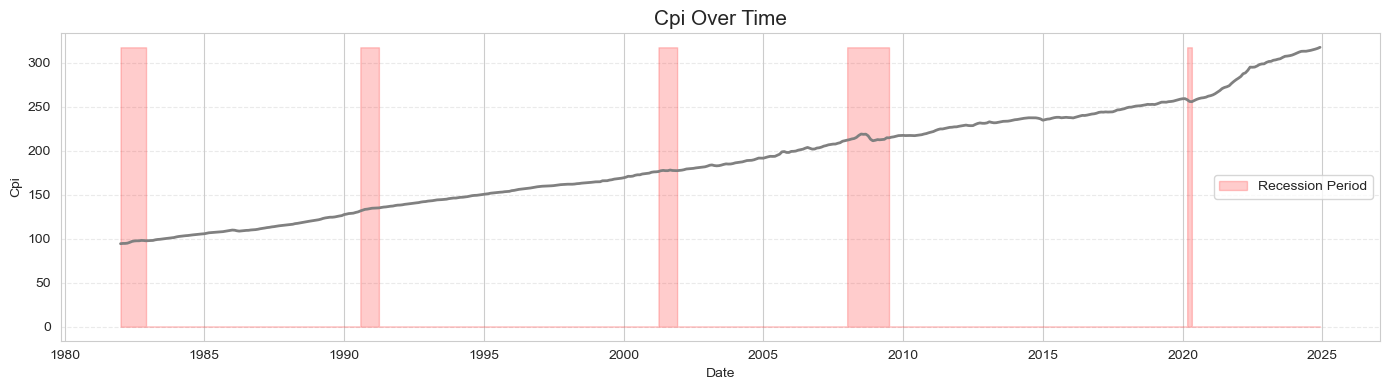

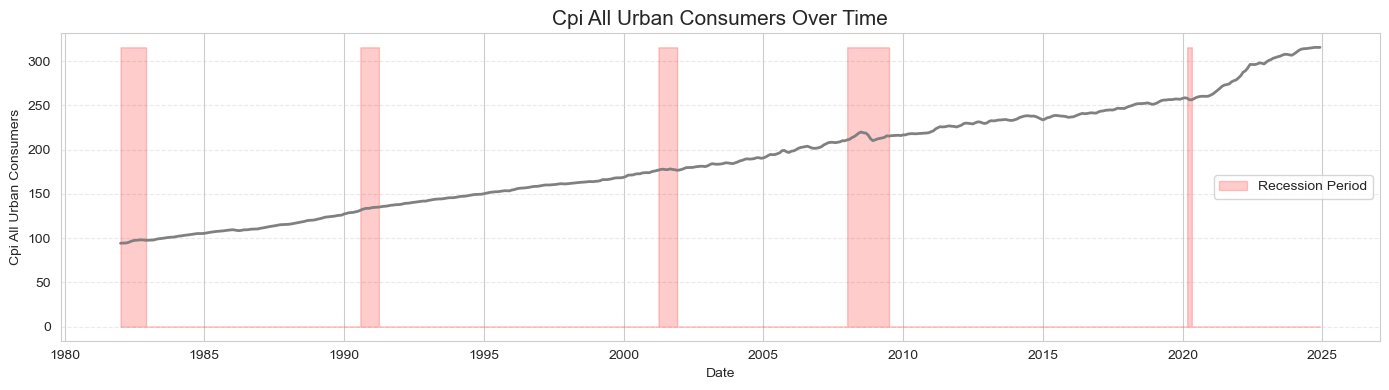

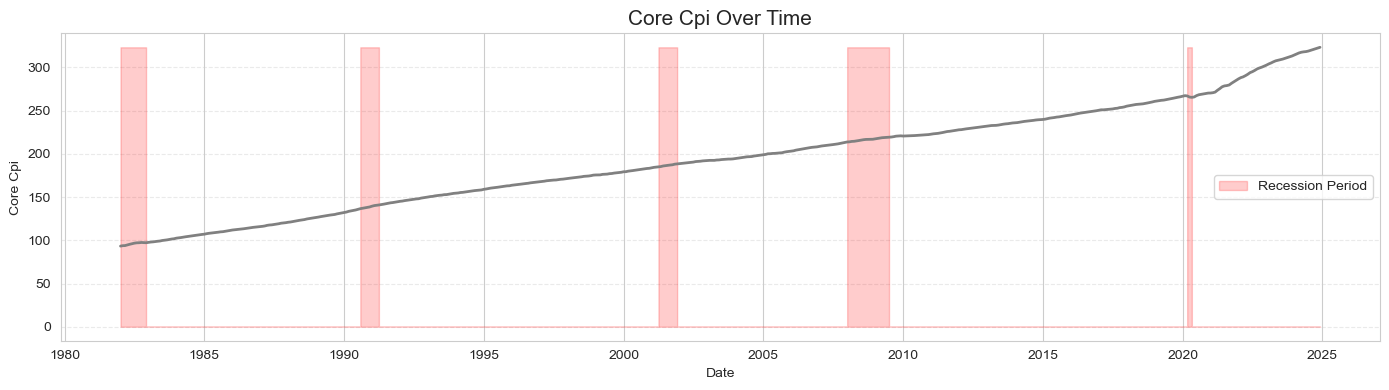

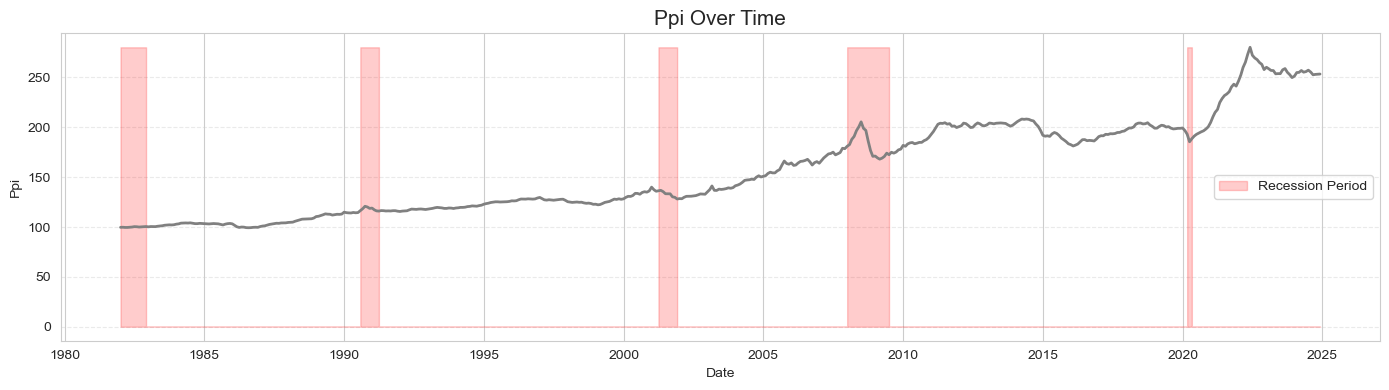

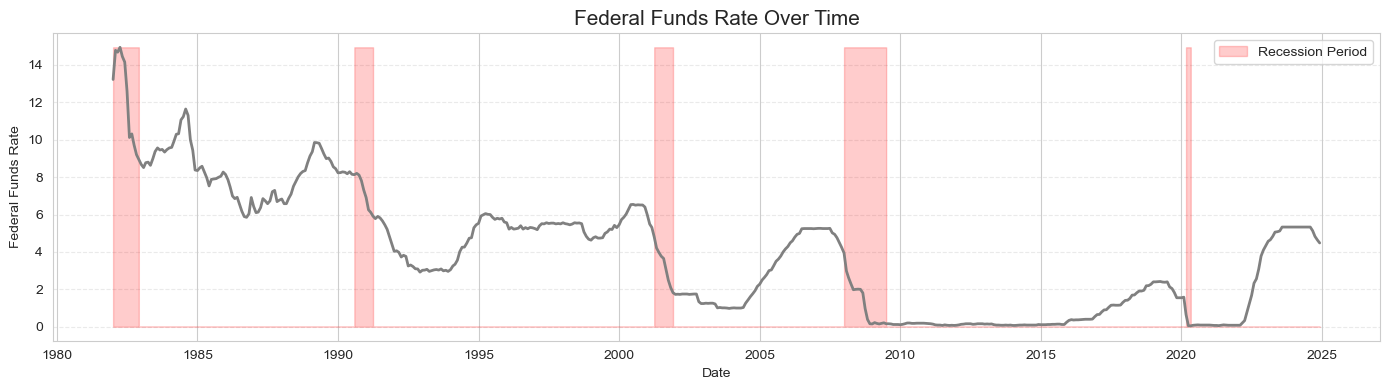

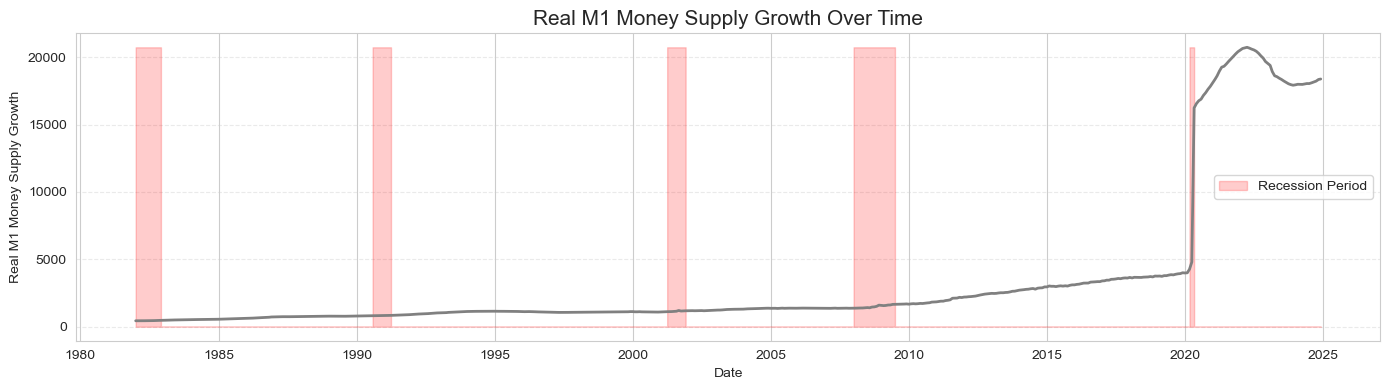

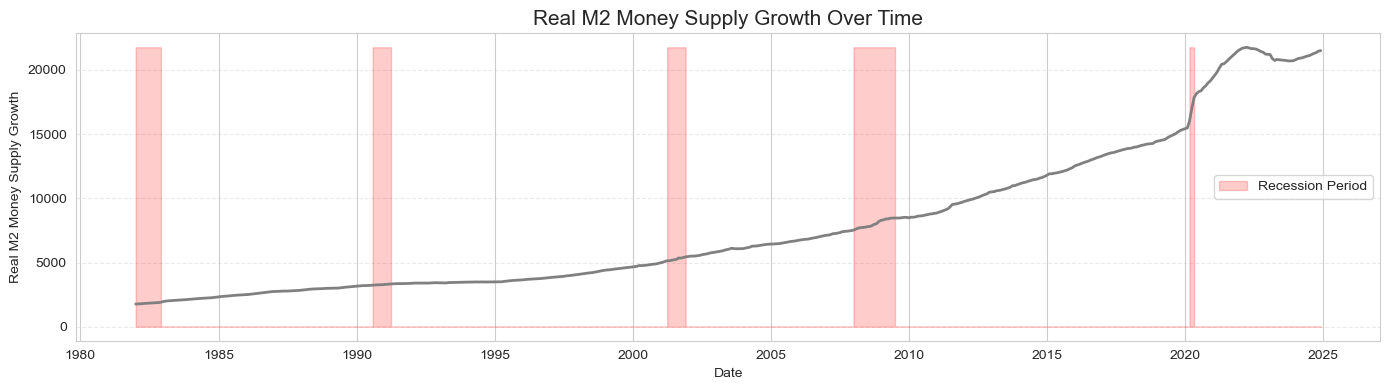

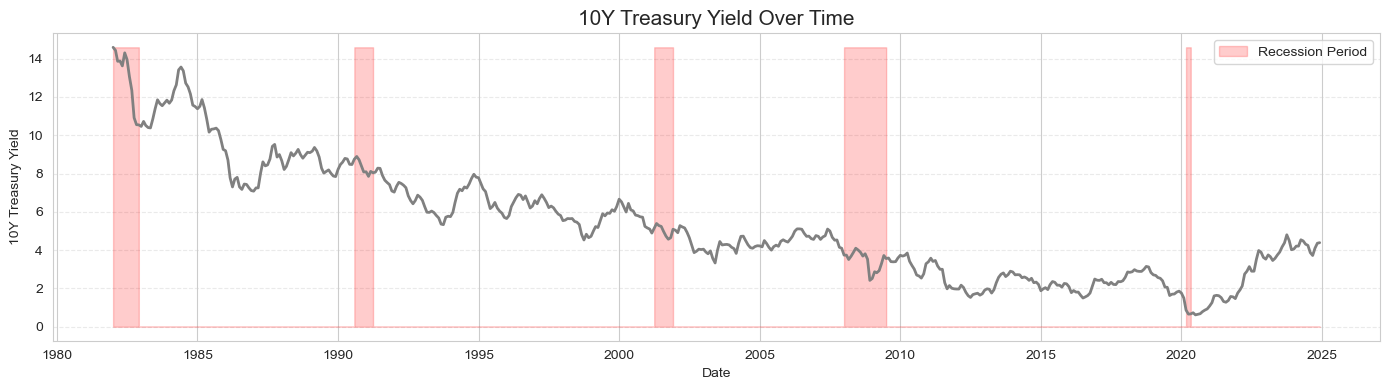

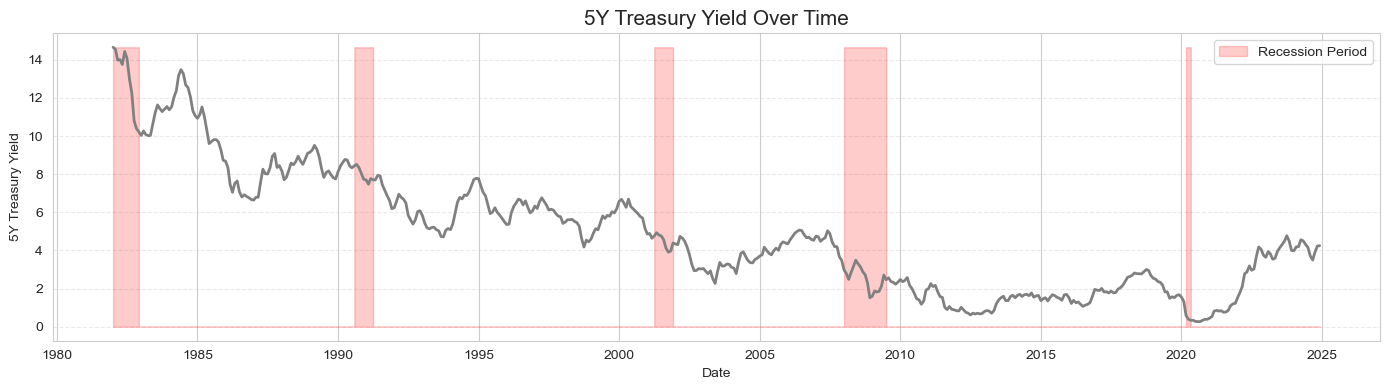

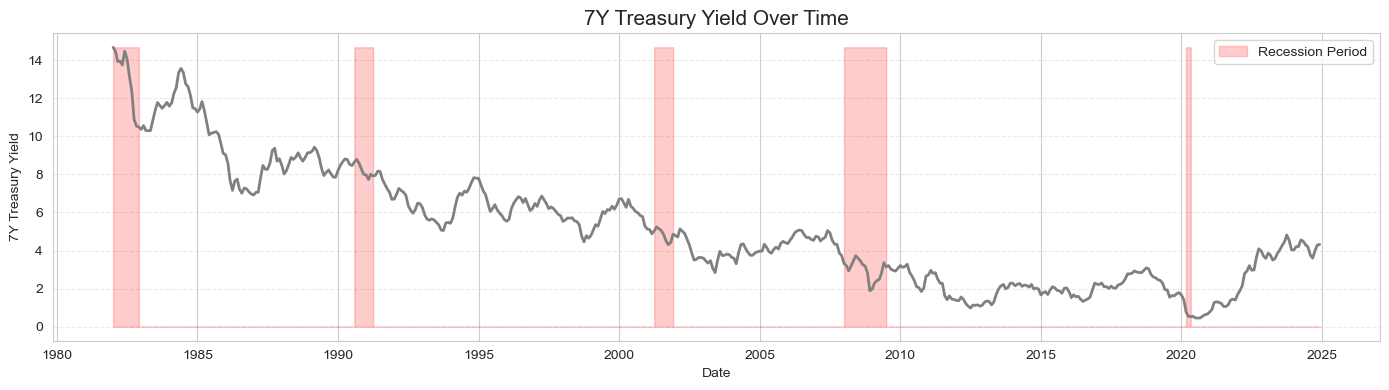

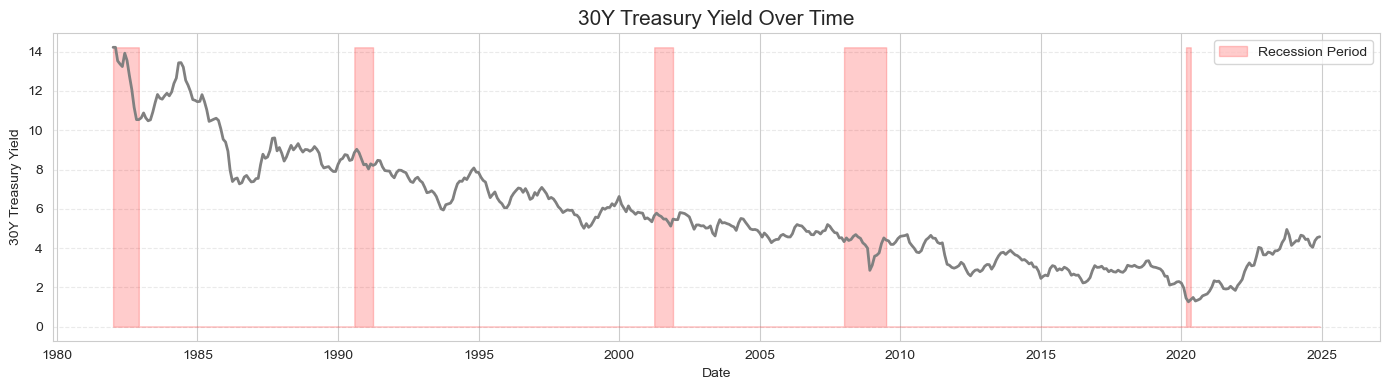

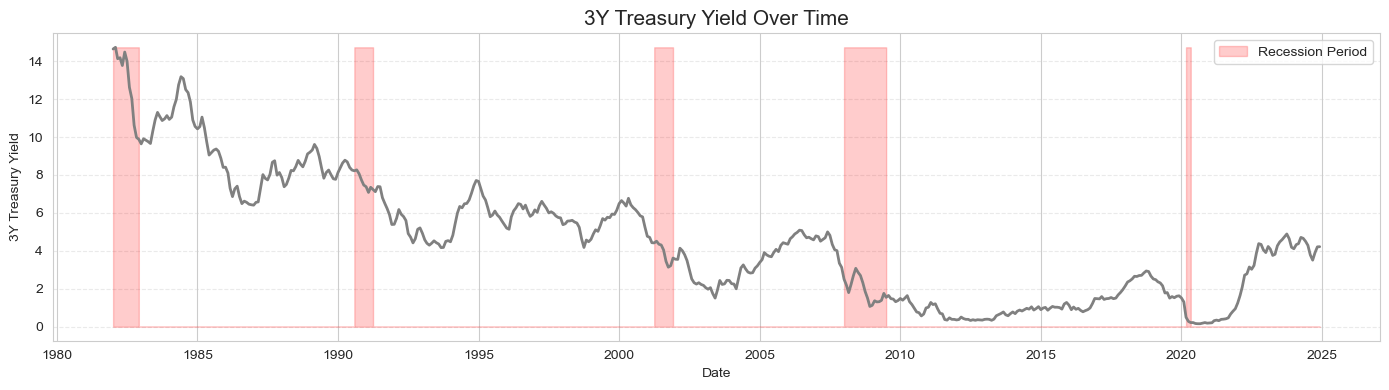

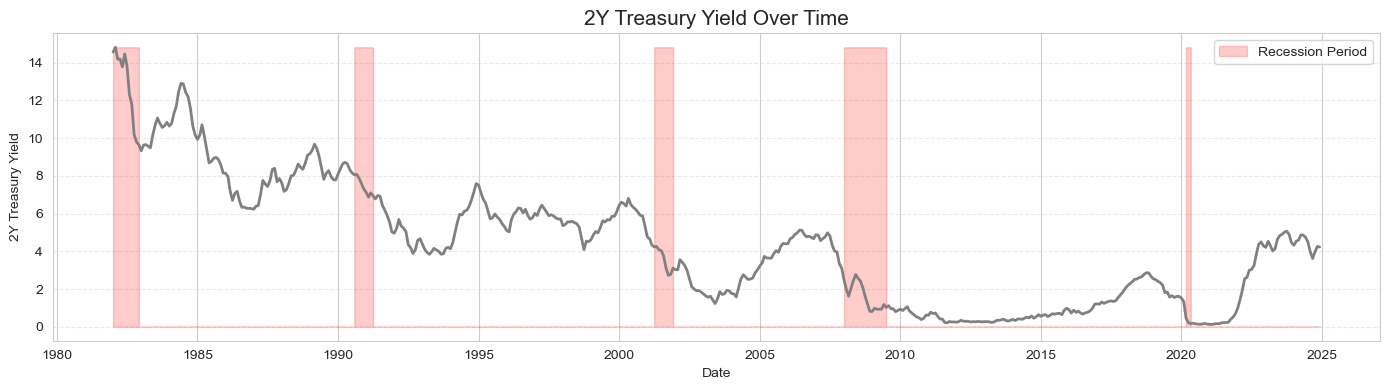

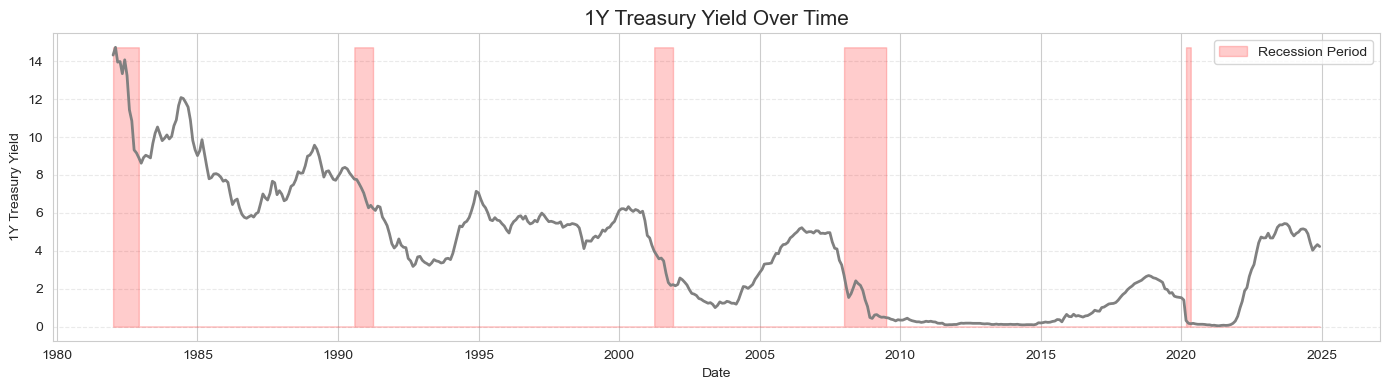

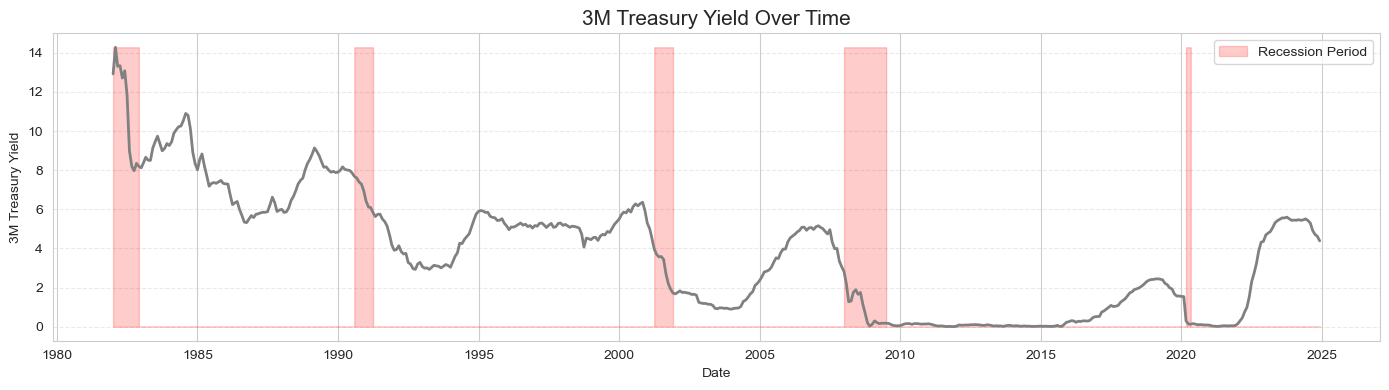

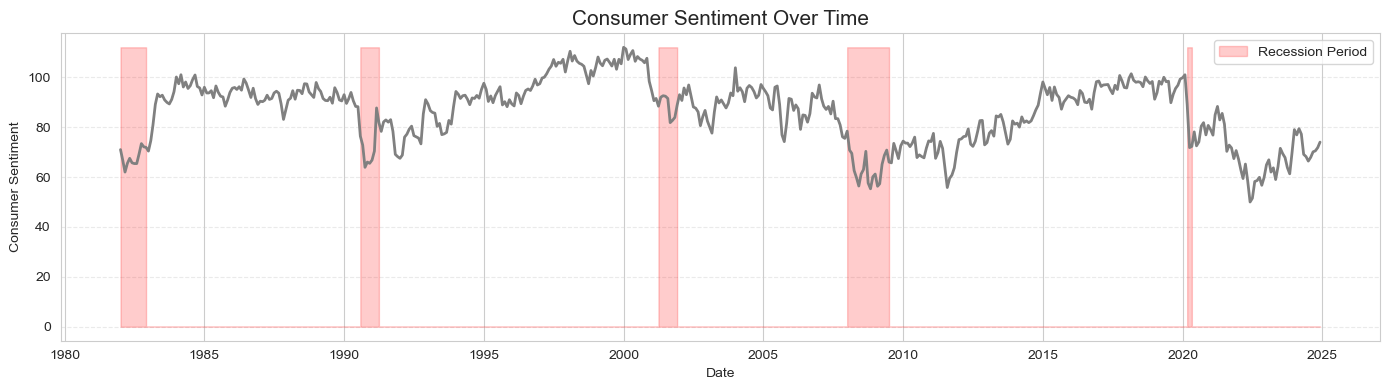

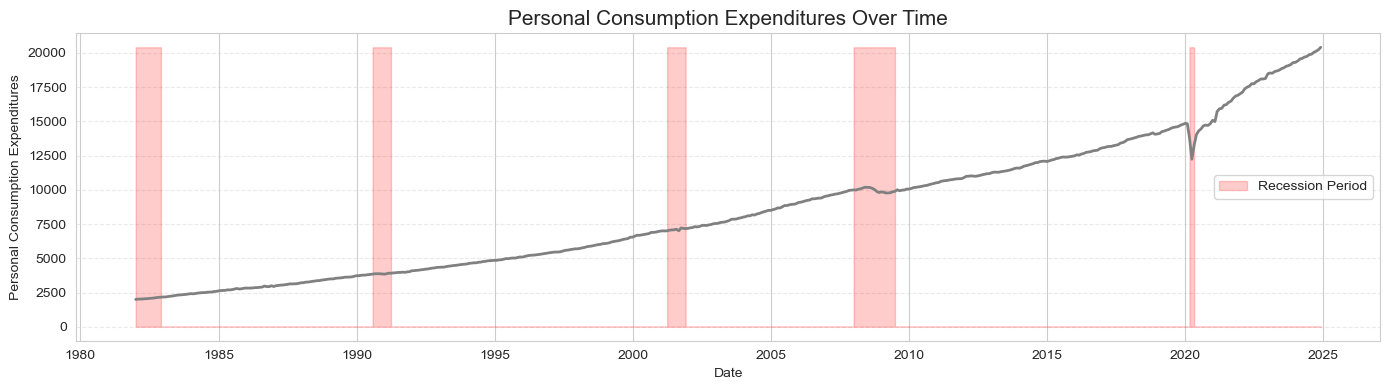

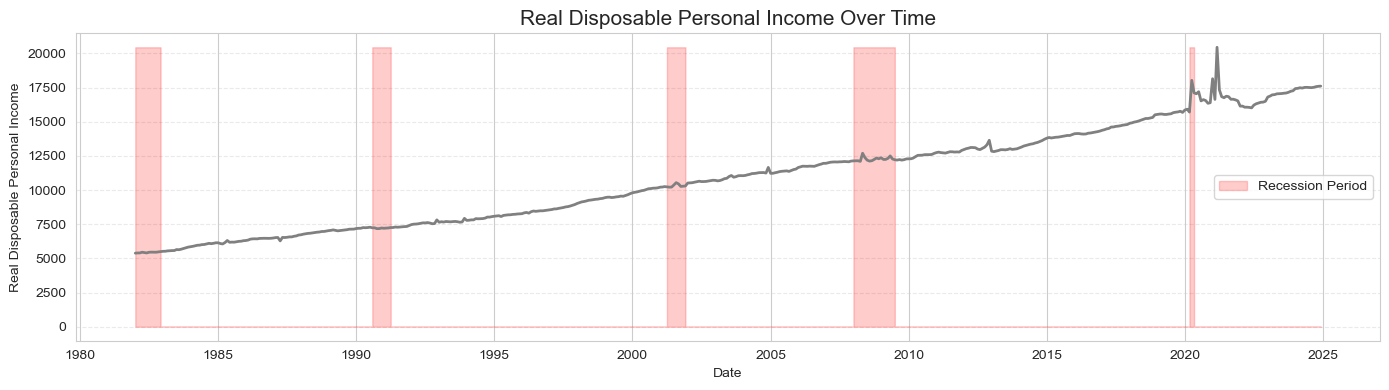

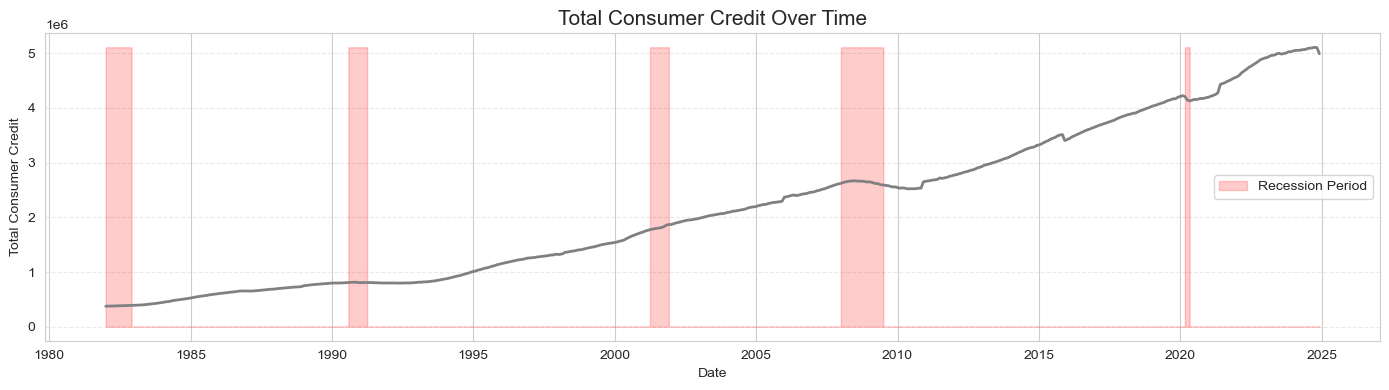

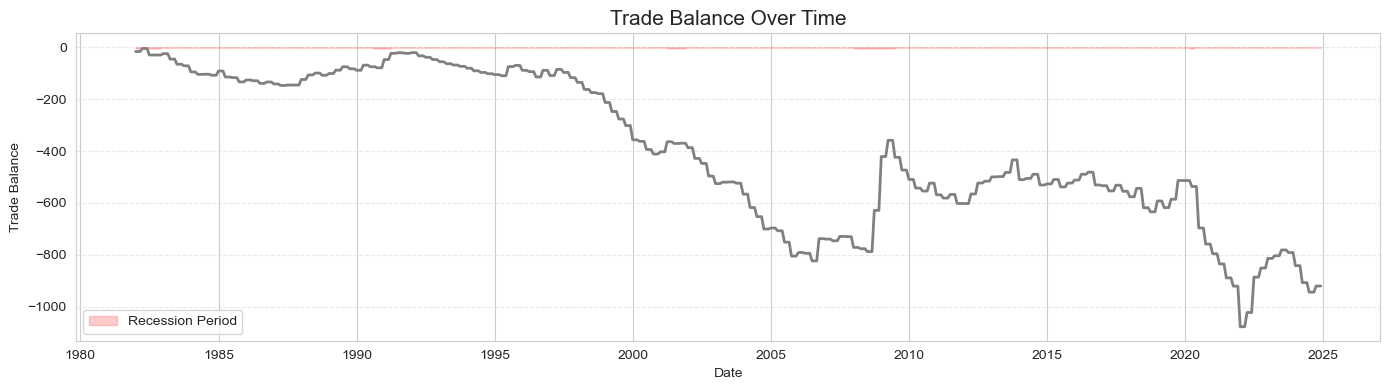

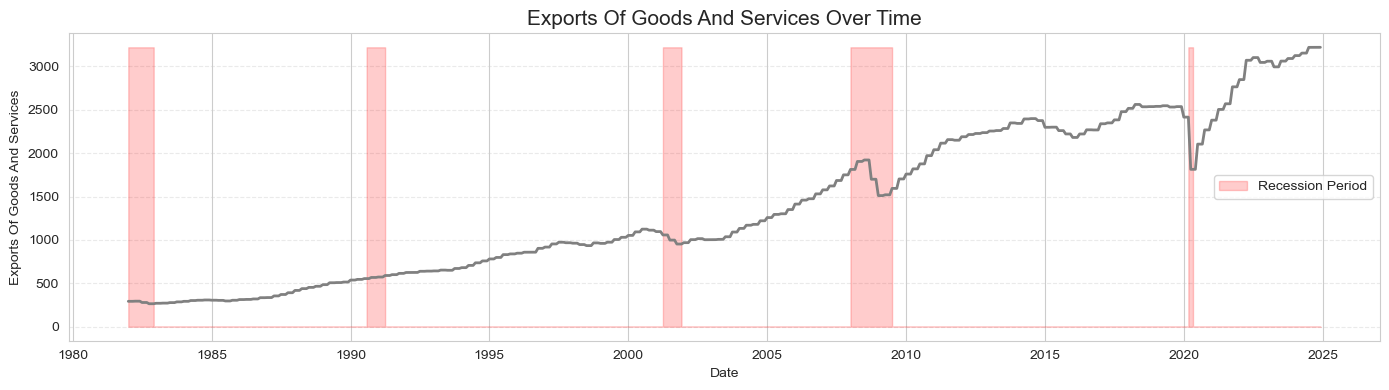

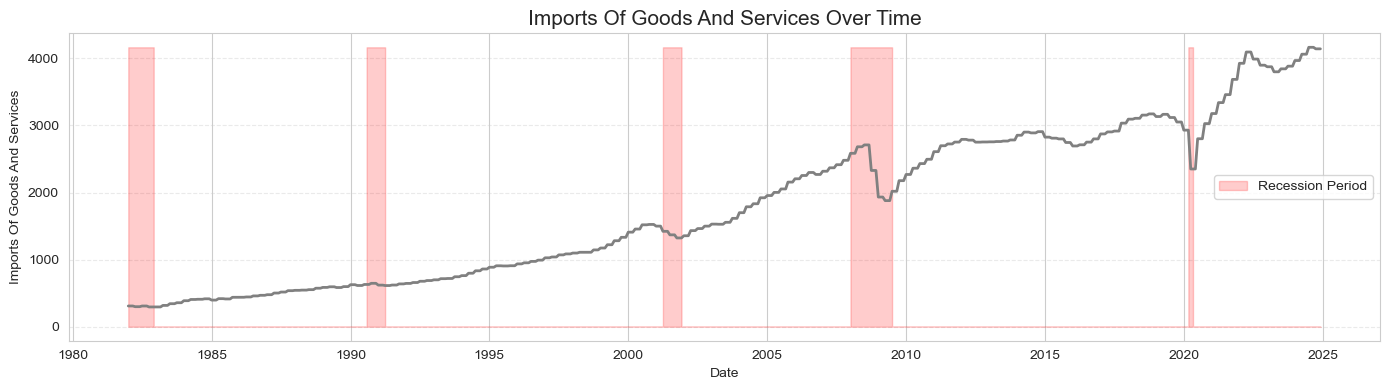

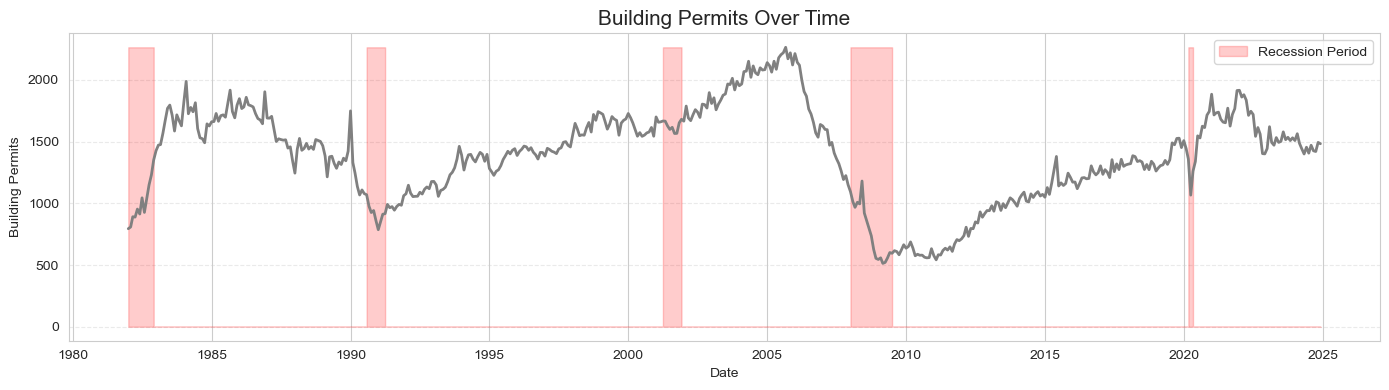

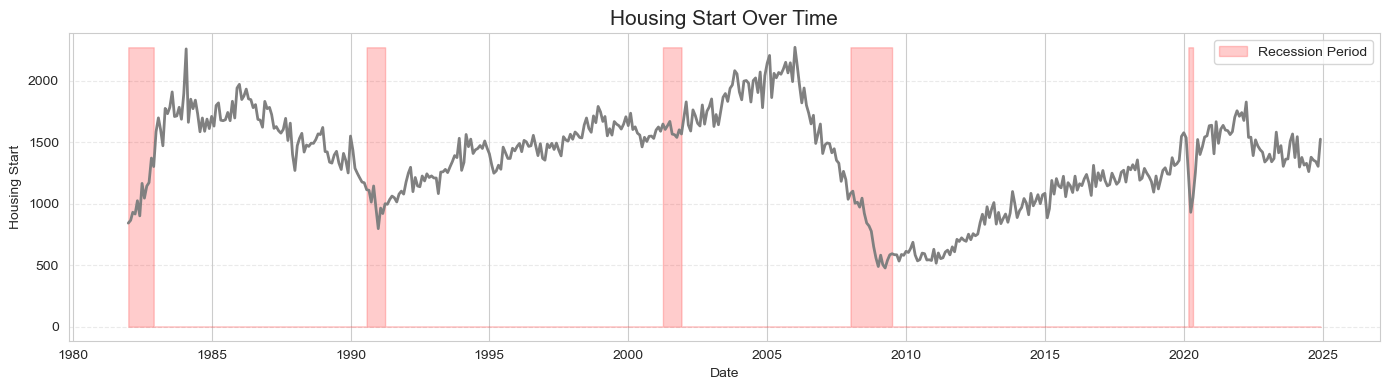

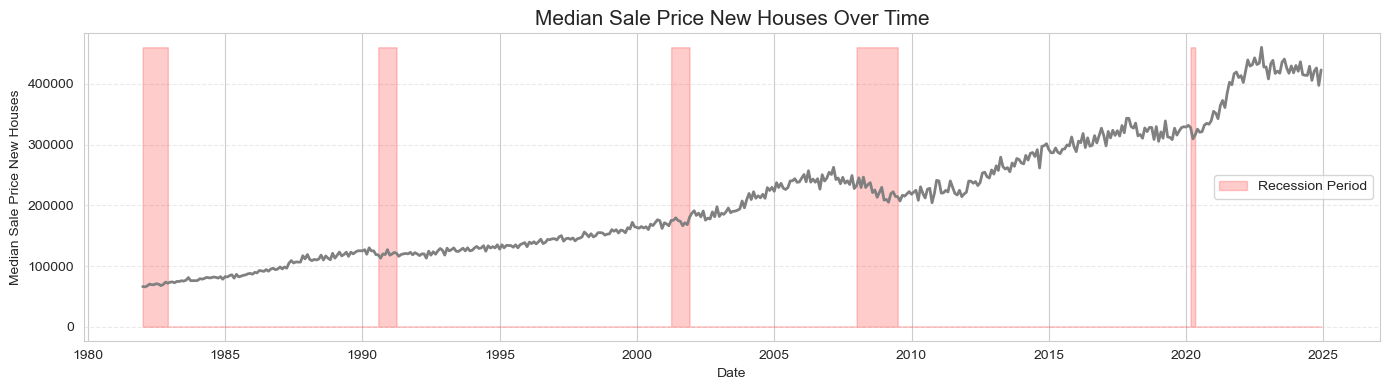

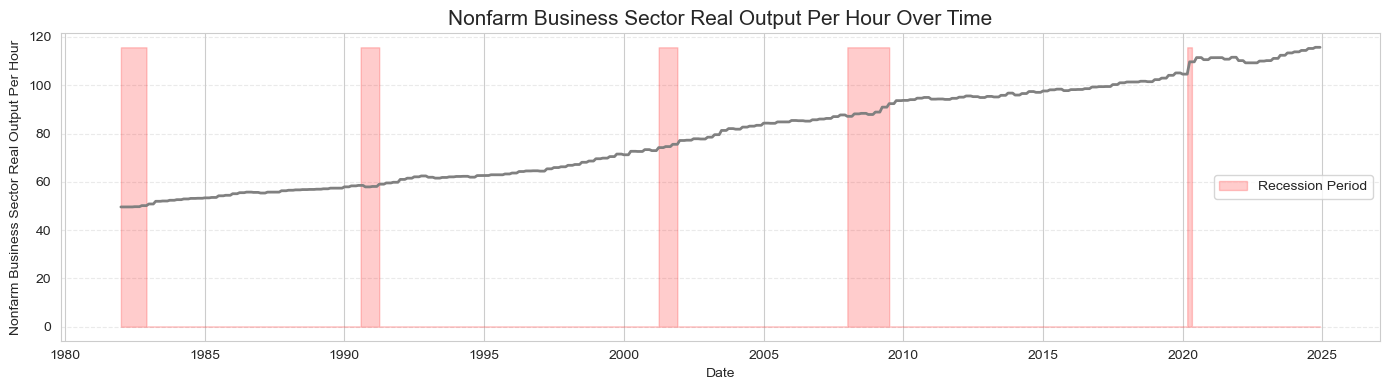

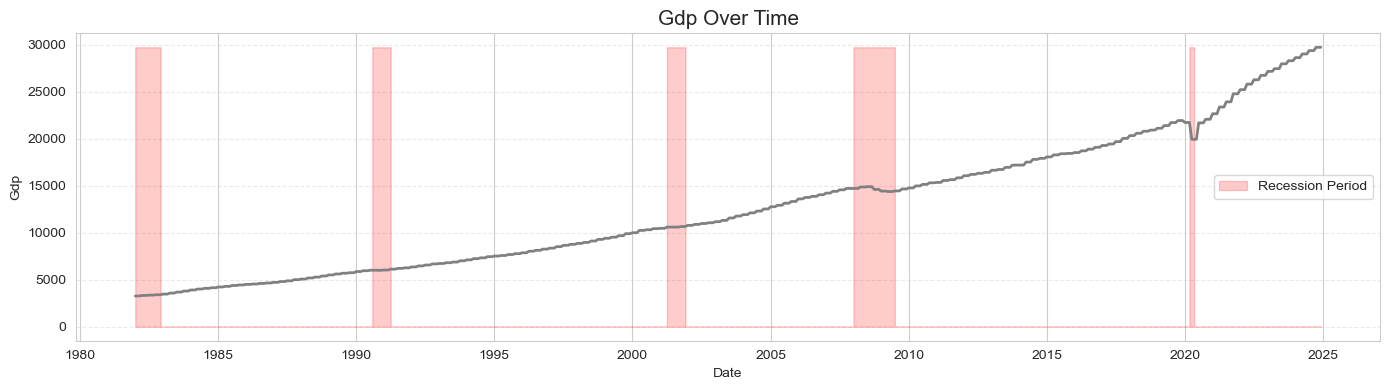

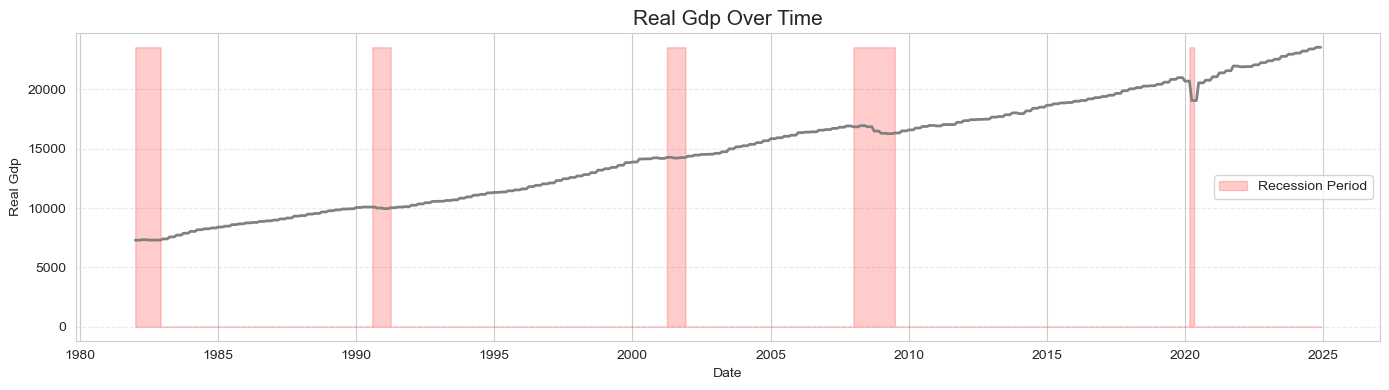

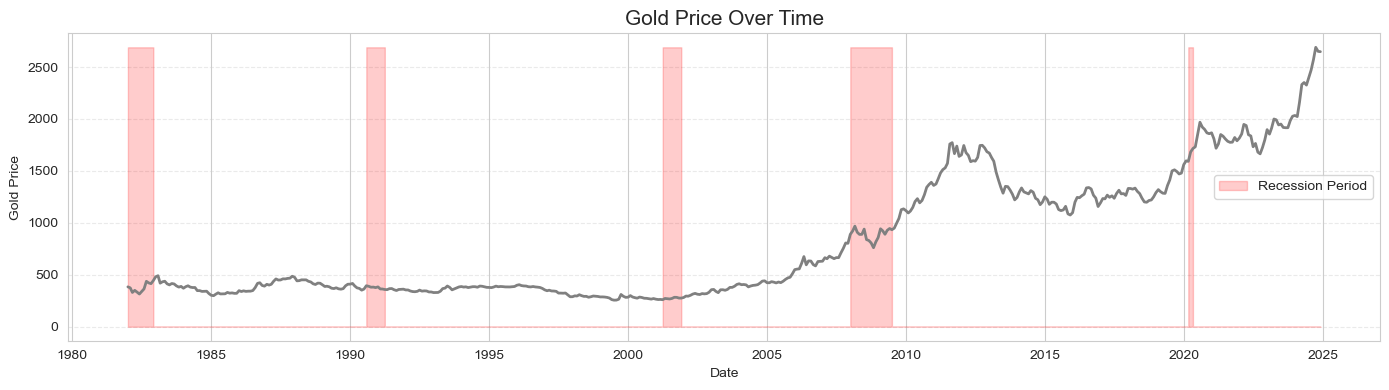

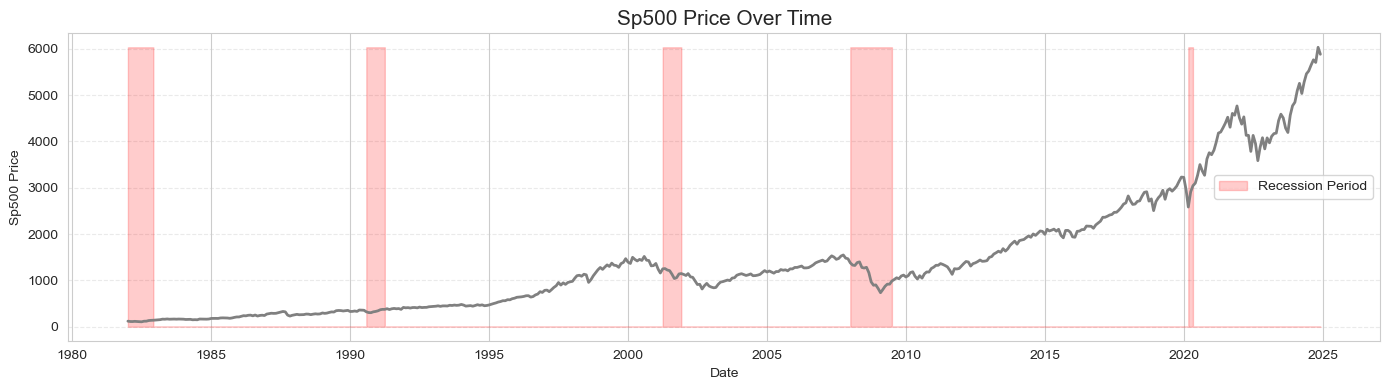

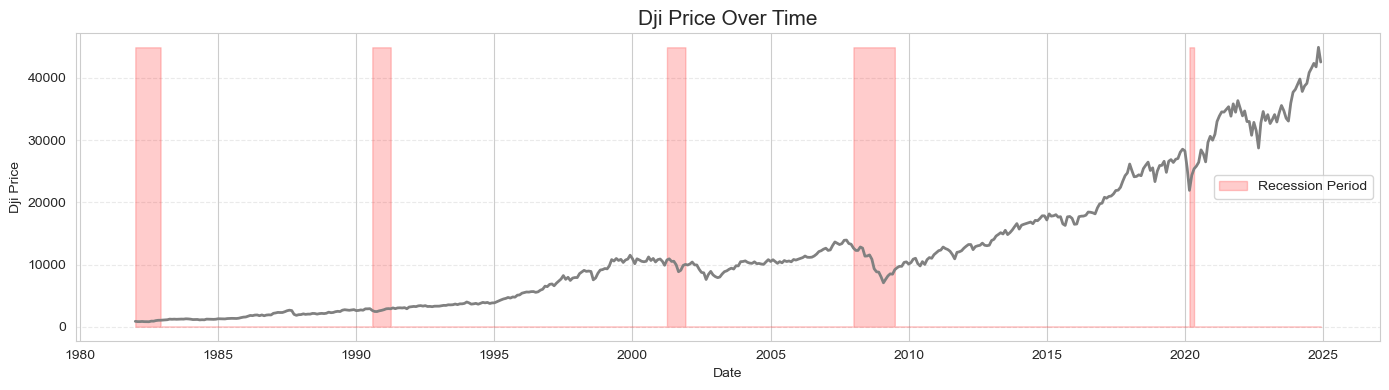

In [ ]:
# Unemployment Rate vs Recession

sns.set_style("whitegrid")
features = final_df.select_dtypes(include = 'number').columns.tolist()
features = [f for f in features if f not in ['recession']]  # exclude target
for feature in features:
    plt.figure(figsize = (14, 4))
    sns.lineplot(data = final_df, x = 'date', y = feature, color = 'gray', linewidth = 2)
    plt.fill_between(
        final_df['date'],
        final_df['recession'] * final_df[feature].max(),
        alpha = 0.2,
        step = 'post',
        color = 'red',
        label = 'Recession Period'
    )
    plt.title(f"{feature.replace('_', ' ').title()} Over Time", fontsize = 15)
    plt.xlabel("Date")
    plt.ylabel(feature.replace('_', ' ').title())
    plt.grid(axis = 'y', linestyle = '--', alpha = 0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



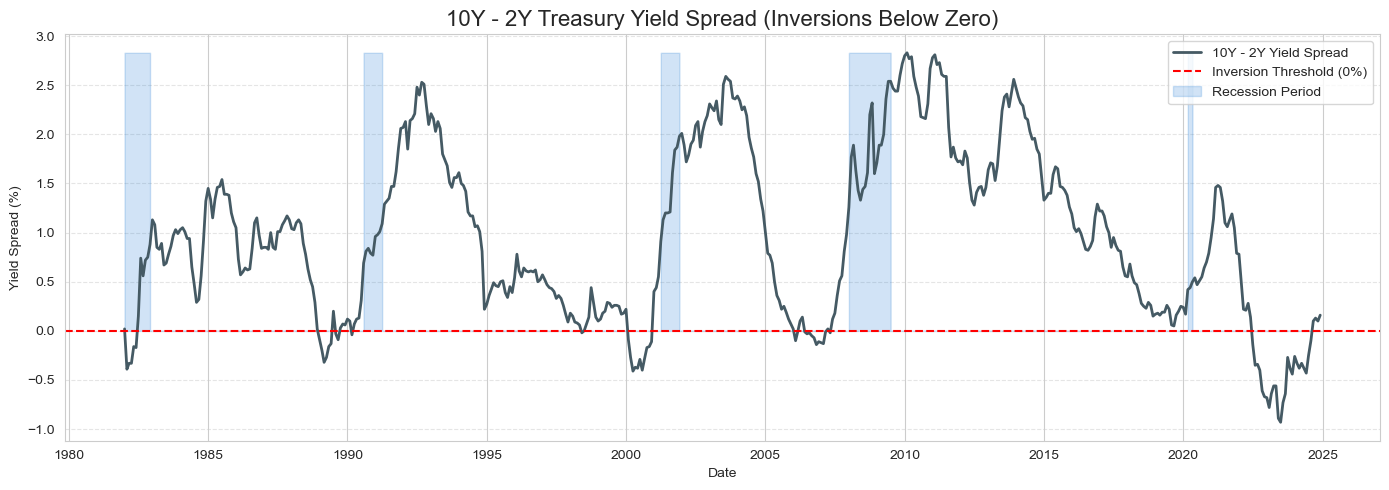

In [ ]:
# Yield Curve Inversion

# Calculate yield spread
final_df['yield_spread_10Y_2Y'] = final_df['10Y_treasury_yield'] - final_df['2Y_treasury_yield']

sns.set_style("whitegrid")
plt.figure(figsize = (14, 5))
sns.lineplot(data = final_df, x = 'date', y = 'yield_spread_10Y_2Y', color = '#455A64', linewidth = 2, label = '10Y - 2Y Yield Spread')
plt.axhline(0, color = 'red', linestyle = '--', linewidth = 1.5, label = 'Inversion Threshold (0%)')
plt.fill_between(
    final_df['date'],
    final_df['recession'] * final_df['yield_spread_10Y_2Y'].max(),
    step = 'post',
    color = '#1976D2',
    alpha = 0.2,
    label = 'Recession Period'
)
plt.title("10Y - 2Y Treasury Yield Spread (Inversions Below Zero)", fontsize = 16)
plt.xlabel("Date")
plt.ylabel("Yield Spread (%)")
plt.legend(loc = 'upper right')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()


The line plot shows the 10Y–2Y yield spread over time, with recessions shaded in blue and the inversion threshold (0%) highlighted with a red dashed line. Periods where the yield spread fell below zero—indicating an inversion—frequently preceded or coincided with the onset of recessions. This visual alignment supports the historical reliability of yield curve inversions as an early warning signal for economic downturns

In [ ]:
final_df.set_index('date', inplace = True)

Train Score: 0.9804560260586319
Test Score: 0.9077669902912622

Classification report for Logit:

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       186
         1.0       1.00      0.05      0.10        20

    accuracy                           0.91       206
   macro avg       0.95      0.53      0.52       206
weighted avg       0.92      0.91      0.87       206



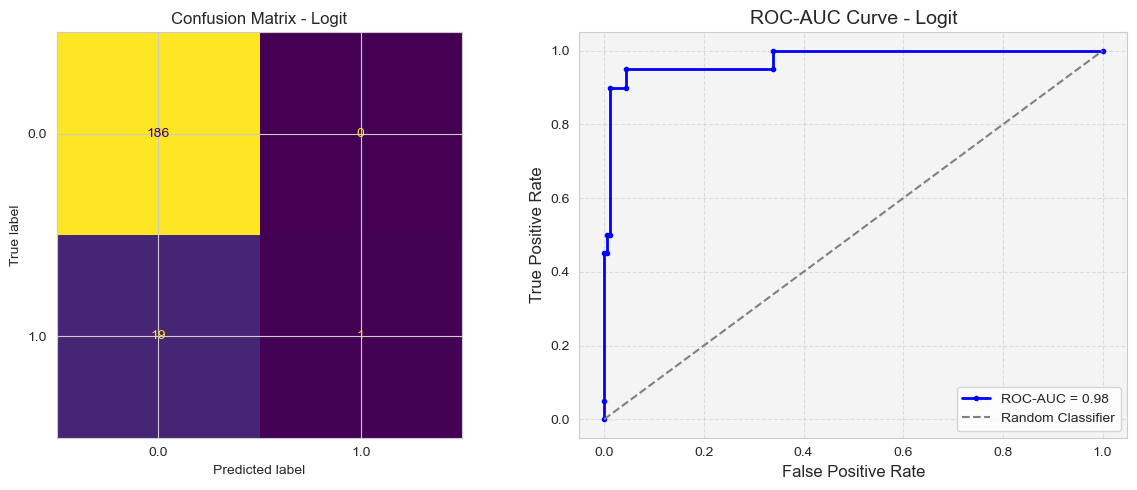

In [ ]:
# Generating lagged features for modeling

def generate_lagged_features(df, target_col, lags = 3):
    df_lagged = df.copy()
    features = [col for col in df.columns if col != target_col]
    for col in features:
        for lag in range(1, lags + 1):
            df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    df_lagged = df_lagged.drop(columns = features)  # Drop current (non-lagged) versions
    return df_lagged.dropna()


df_lagged = generate_lagged_features(final_df, target_col = 'recession', lags = 3)

# Define features and target
X = df_lagged.drop(columns = 'recession')
y = df_lagged['recession']

# Chronological split: first 60% train, rest test
split_idx = int(len(X) * 0.6)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Preprocessing pipeline
numerical_columns = X.columns.tolist()
preprocessor_logit = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_columns),
])

logit_pipeline = Pipeline([
    ('preprocessor', preprocessor_logit),
    ('logit', LogisticRegression(random_state = 42, class_weight = 'balanced'))
])

# Train and evaluate
logit_pipeline.fit(X_train, y_train)
y_pred = logit_pipeline.predict(X_test)
y_proba = logit_pipeline.predict_proba(X_test)[:, 1]

train_score = logit_pipeline.score(X_train, y_train)
test_score = logit_pipeline.score(X_test, y_test)

y_pred = logit_pipeline.predict(X_test)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

print(f'\nClassification report for Logit:\n')
print(classification_report(y_test, y_pred, zero_division=0))

# Subplots for confusion matrix and precision-recall curve
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Confusion matrix
cm = confusion_matrix(y_test, logit_pipeline.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logit_pipeline.classes_)
disp.plot(ax = axes[0], colorbar = False)
axes[0].set_title(f'Confusion Matrix - Logit')

# ROC-AUC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, logit_pipeline.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, marker = '.', color = 'b', label = f'ROC-AUC = {roc_auc:.2f}', linewidth = 2)  # Line style & color
axes[1].plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Classifier')  # Diagonal line for random guessing
axes[1].set_xlabel('False Positive Rate', fontsize = 12)
axes[1].set_ylabel('True Positive Rate', fontsize = 12)
axes[1].set_title(f'ROC-AUC Curve - Logit', fontsize = 14)
axes[1].legend(loc = 'lower right', fontsize = 10)
axes[1].grid(True, linestyle = '--', alpha = 0.6)  
axes[1].set_facecolor('#f4f4f4')  
plt.tight_layout()
plt.show()


The model shows a strong fit on the training data with a high score of 0.98, but it struggles with generalizing to unseen data, as reflected in the lower test score of 0.91. This discrepancy suggests potential overfitting, where the model has learned the patterns of the training data well but fails to capture the minority class effectively on the test data. Specifically, for the target class "1.0" (recession), the model has perfect precision (1.00), indicating that when it predicts a recession, it is almost always correct. However, the recall for this class is very low (0.05), meaning the model misses most actual recession periods, leading to a high number of false negatives. This is also reflected in the low F1-score of 0.10 for the recession class, highlighting poor performance in predicting the minority class. On the other hand, the model performs well for the majority class "0.0" (no recession), with a high precision (0.91), perfect recall (1.00), and a strong F1-score (0.95). The macro average scores show the imbalance, with recall for the minority class being significantly lower, while the weighted average scores are skewed due to the dominance of the majority class. This indicates that the model is biased towards predicting no recession, leading to poor performance in identifying recession periods. To improve performance, especially in predicting recessions, techniques like resampling, adjusting class weights, or threshold tuning could be explored. Additionally, experimenting with different models or further feature engineering might help capture more nuanced patterns in the data

Top important features for predicting recession:

                           Feature  Coefficient
66         consumer_sentiment_lag1    -1.355672
10          unemployment_rate_lag2    -1.223537
107                gold_price_lag3    -1.037341
67         consumer_sentiment_lag2    -0.999519
11          unemployment_rate_lag3    -0.939124
9           unemployment_rate_lag1    -0.822574
17   laborforce_participation_lag3     0.761231
106                gold_price_lag2    -0.743641
6        real_GDP_growth_rate_lag1    -0.732805
3        capacity_utilization_lag1    -0.708026


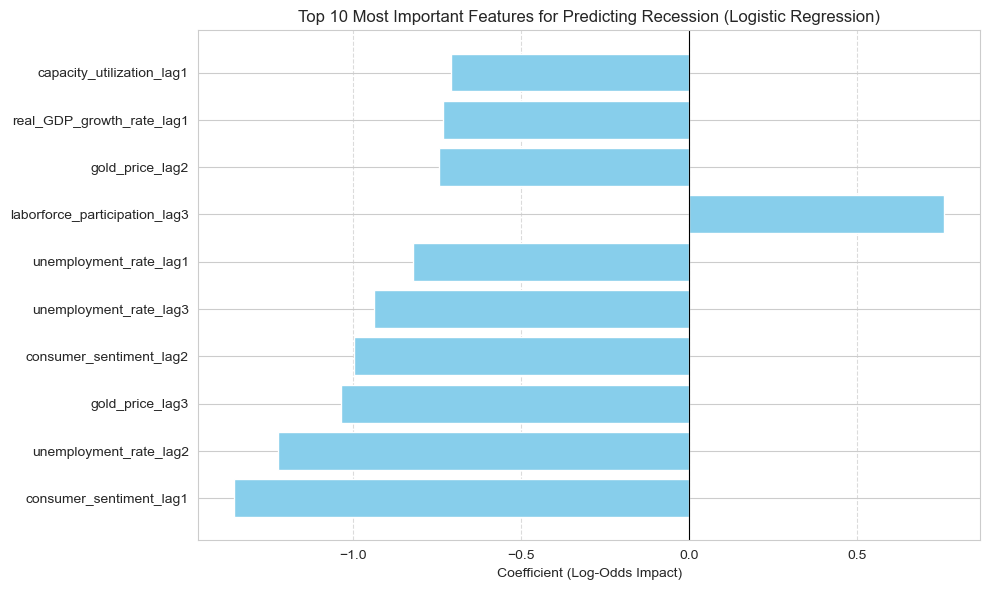

In [ ]:
# Feature Importance Analysis
# Extracting feature names and coefficients for baseline logistic regression
scaled_feature_names = preprocessor_logit.named_transformers_['num'].get_feature_names_out(numerical_columns)

coefficients = logit_pipeline.named_steps['logit'].coef_[0]

feature_importance = pd.DataFrame({
    'Feature': scaled_feature_names,
    'Coefficient': coefficients,
    'AbsCoefficient': np.abs(coefficients)
})

feature_importance.sort_values(by = 'AbsCoefficient', ascending = False, inplace = True)

print("Top important features for predicting recession:\n")
print(feature_importance[['Feature', 'Coefficient']].head(10))

plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance["Feature"].head(10), feature_importance["Coefficient"].head(10), color = 'skyblue')
plt.axvline(0, color = 'black', linewidth = 0.8)
plt.title("Top 10 Most Important Features for Predicting Recession (Logistic Regression)")
plt.xlabel("Coefficient (Log-Odds Impact)")
plt.tight_layout()
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)
plt.show()

The logistic regression model highlighted the top 10 most influential lagged economic indicators associated with recession prediction. The strongest predictor was consumer_sentiment_lag1, with a large negative coefficient (-1.36), indicating that a sharp decline in consumer confidence one month prior is a strong signal of an approaching recession. This was closely followed by unemployment_rate_lag2 (-1.22), suggesting that higher unemployment levels two months earlier are a strong precursor to economic contraction. Gold_price_lag3 (-1.04) and consumer_sentiment_lag2 (-1.00) also showed strong negative associations, reflecting both investor caution and sustained consumer pessimism over multiple periods. The third lag of unemployment rate (unemployment_rate_lag3, -0.94) further confirmed that deteriorating labor market conditions are robust early warnings. Interestingly, laborforce_participation_lag3 had a positive coefficient (0.76), potentially indicating temporary resilience in labor force engagement before broader economic impacts materialize. Gold_price_lag2 (-0.74), real_gdp_growth_rate_lag1 (-0.73), and capacity_utilization_lag1 (-0.71) all demonstrated negative contributions, highlighting that contraction in economic output, production efficiency, and investor flight to safety typically precede recessions. Lastly, building_permits_lag1 (-0.68) also negatively correlated with recession, underscoring the importance of a slowdown in housing activity as a leading indicator. Collectively, these variables provide a comprehensive, lagged view of consumer, labor, investment, and industrial signals that meaningfully anticipate economic downturns.